In [70]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
from IPython.display import display
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
from skimage import measure,color,morphology
from scipy.stats import norm
from PIL import Image
import math
import shutil
# from tqdm import tqdm

# ======

def img_show(img_mtx, figsize=(6,6)):

    '''Convert pixel matrix into png image without axis
    '''
    plt.figure(figsize=figsize)
    plt.imshow(img_mtx, cmap='gray')
    plt.axis('off')
    plt.show() 

# === Function(Convert png image into pixel matrix) ===

def img_arr(image_path,multi=1):
    try:
        with Image.open(image_path) as img:
            img = img.convert('L')
            img.load()
            img_array = np.array(img,np.uint8)
            img = img.resize((img_array.shape[0]*multi,img_array.shape[1]*multi),resample=Image.ANTIALIAS)
            array = np.array(img,np.uint8)
            array.setflags(write=1)
            return array
    except OSError as e:
        raise OSError("Failed to open image file") from e 

In [122]:
"""Get the width and height of the terminal window.
"""

width, height = shutil.get_terminal_size((80, 20))

"""
    :param work_dir (str) : Current working directory
    :param main_dir (str) : Always be set to ./SuperBone_ver1
    :param output_dir (str) : The default directory where all outputs are stored
"""  

work_dir = os.getcwd()
main_dir = os.path.dirname(work_dir)
initial_dir = os.path.join(main_dir,'img_src')   
output_dir = os.path.join(main_dir,'analyze_figure','cal_line')

import FileChooser

"""Initialize the class and set the initial directory, file type, and the type of file/folder to choose

    :param initial_dir (str) : Initial directory to open the file dialog
    :param file_type (str) : The type of file to select (e.g. "Image", "DICOM",...)
    :param choose_type (str) : The type of file/folder to select ("File", "Folder", "Multiple Files")
"""  

selector = FileChooser.Selector(initial_dir, file_type = "PNG", choose_type = "File")

"""Open a file dialog windows and return the source path

    :param file_src_path (str) : The absolute path of the source image
"""

file_src_path = selector.run()

Import File : C:/Users/marsh/OneDrive/桌面/SuperBone_ver1.30/img_src/pattern_src_1/M_CERVUS_D_METATARSUS_ID[033]_s[56]_x[80]_y[60].png


C:\Users\marsh\AppData\Local\Temp\ipykernel_15784\3501920769.py:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((img_array.shape[0]*multi,img_array.shape[1]*multi),resample=Image.ANTIALIAS)


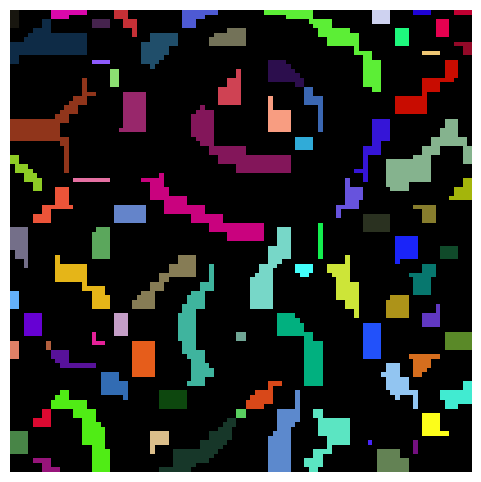

In [135]:
from skimage import measure,color

resize_img = img_arr(file_src_path) 
resize_img = resize_img/np.max(resize_img)
resize_img = resize_img*255
#img_show(resize_img)
save_path = os.path.join(output_dir,'original.png')
plt.imsave(save_path,resize_img,cmap='gray')

horizontal = np.copy(resize_img)
vertical = np.copy(resize_img)
cols = horizontal.shape[1]
horizontal_size = cols // 10

horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))

horizontal = cv.erode(horizontal, horizontalStructure)
horizontal = cv.dilate(horizontal, horizontalStructure)
horizontal = horizontal/2
# img_show(horizontal)
save_path = os.path.join(output_dir,'horizontal.png')
plt.imsave(save_path,horizontal,cmap='gray')

rows = vertical.shape[0]
vertical_size = rows // 10

verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))

vertical = cv.erode(vertical, verticalStructure)
vertical = cv.dilate(vertical, verticalStructure)
vertical = vertical/2
# img_show(vertical)
save_path = os.path.join(output_dir,'vertical.png')
plt.imsave(save_path,vertical,cmap='gray')

joints_img = cv.add(horizontal, vertical)
joints_img = joints_img/np.max(joints_img)
_, joints_thresh = cv.threshold(joints_img,0.9,1,cv.THRESH_BINARY)

kernel = np.ones((3,3), np.uint8)
joints_thresh = cv.dilate(joints_thresh, kernel)

segment_img = resize_img.copy()
segment_img[np.where(joints_thresh>0)] = 0
save_path = os.path.join(output_dir,'non_joints.png')
plt.imsave(save_path,segment_img,cmap='gray')

segment_img = segment_img/2
resize_img = resize_img/2
new_img = cv.add(segment_img, resize_img)
# img_show(new_img)
save_path = os.path.join(output_dir,'joints.png')
plt.imsave(save_path,new_img,cmap='gray')

labels = measure.label(segment_img, background=0, connectivity=1)

nlabel = len(np.unique(labels))
dst = color.label2rgb(labels, colors=np.random.random((nlabel, 3)))
img_show(dst)   
save_path = os.path.join(output_dir,'dst.png')
plt.imsave(save_path,dst,cmap='gray')
     
for i, region in enumerate(measure.regionprops(labels)):
    if region.perimeter > 0:
        black_img = np.zeros((resize_img.shape[0], resize_img.shape[1]))
        black_img[region.coords[:,0],region.coords[:,1]] = 1
        skel, distance = morphology.medial_axis(black_img, return_distance=True)
        dist_on_skel = distance*skel             

        _, skel_thresh = cv.threshold(dist_on_skel,0,1,cv.THRESH_BINARY)
        line_length = np.count_nonzero(skel_thresh>0)
        line_area = region.area
        line_width = line_area/line_length
        length = max(region.bbox[3]-region.bbox[1], region.bbox[2]-region.bbox[0])
        curl = length/line_length